# Vehicle_01 Location Analysis for 2025-04-22

This notebook analyzes GPS location data for vehicle_01 on April 22, 2025, retrieved from DynamoDB and displayed on interactive maps with comprehensive analysis.

In [27]:
# Import required libraries
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from datetime import datetime, timedelta
from boto3.dynamodb.conditions import Key
from decimal import Decimal
import json
import math
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [28]:
# Configuration
VEHICLE_ID = 'vehicle_01'
TARGET_DATE = '2025-04-22'
AWS_REGION = 'eu-central-1'
TABLE_NAME = 'gps-tracking-service-dev-locations-v2'  # Update this based on your environment

# Calculate epoch timestamps for the target date
start_date = datetime.strptime(TARGET_DATE, '%Y-%m-%d')
end_date = start_date + timedelta(days=1)

start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

print(f"Querying data for {VEHICLE_ID} on {TARGET_DATE}")
print(f"Start timestamp: {start_timestamp} ({start_date})")
print(f"End timestamp: {end_timestamp} ({end_date})")

Querying data for vehicle_01 on 2025-04-22
Start timestamp: 1745272800 (2025-04-22 00:00:00)
End timestamp: 1745359200 (2025-04-23 00:00:00)


In [29]:
# Initialize DynamoDB connection
def init_dynamodb():
    """
    Initialize DynamoDB connection.
    Make sure your AWS credentials are configured (via AWS CLI, environment variables, or IAM role)
    """
    try:
        dynamodb = boto3.resource('dynamodb', region_name=AWS_REGION)
        table = dynamodb.Table(TABLE_NAME)
        print(f"Successfully connected to DynamoDB table: {TABLE_NAME}")
        return table
    except Exception as e:
        print(f"Error connecting to DynamoDB: {e}")
        print("\nMake sure your AWS credentials are configured:")
        print("1. AWS CLI: aws configure")
        print("2. Environment variables: AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY")
        print("3. IAM role (if running on EC2)")
        return None

table = init_dynamodb()

Successfully connected to DynamoDB table: gps-tracking-service-dev-locations-v2


In [30]:
# Utility functions
def decimal_default(obj):
    """Convert Decimal objects to float for JSON serialization"""
    if isinstance(obj, Decimal):
        return float(obj)
    raise TypeError

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on Earth"""
    R = 6371000  # Earth radius in meters
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2) ** 2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def calculate_speed(distance_meters, time_seconds):
    """Calculate speed in km/h from distance and time"""
    if time_seconds == 0:
        return 0
    return (distance_meters / time_seconds) * 3.6  # Convert m/s to km/h

In [31]:
# Query DynamoDB for vehicle data
def query_vehicle_data(table, vehicle_id, start_ts, end_ts):
    """
    Query DynamoDB for vehicle location data within a time range
    """
    if table is None:
        print("No DynamoDB connection available")
        return []
    
    try:
        print(f"Querying DynamoDB for {vehicle_id} from {start_ts} to {end_ts}...")
        
        # Query with pagination to handle large datasets
        all_items = []
        last_evaluated_key = None
        
        while True:
            query_params = {
                'KeyConditionExpression': Key('id').eq(vehicle_id) & Key('timestamp').between(start_ts, end_ts),
                'ScanIndexForward': True  # Sort by timestamp ascending
            }
            
            if last_evaluated_key:
                query_params['ExclusiveStartKey'] = last_evaluated_key
            
            response = table.query(**query_params)
            items = response.get('Items', [])
            all_items.extend(items)
            
            last_evaluated_key = response.get('LastEvaluatedKey')
            if not last_evaluated_key:
                break
                
            print(f"Retrieved {len(items)} items, continuing...")
        
        print(f"Total items retrieved: {len(all_items)}")
        return all_items
        
    except Exception as e:
        print(f"Error querying DynamoDB: {e}")
        return []

# Query the data
raw_data = query_vehicle_data(table, VEHICLE_ID, start_timestamp, end_timestamp)

Querying DynamoDB for vehicle_01 from 1745272800 to 1745359200...
Total items retrieved: 1733


In [32]:
# Convert to DataFrame and process data
def process_location_data(raw_data):
    """
    Convert raw DynamoDB data to processed DataFrame
    """
    if not raw_data:
        print("No data to process")
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(raw_data)
    
    # Convert Decimal to float
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
    
    # Convert timestamp to datetime
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Calculate derived metrics
    if len(df) > 1:
        # Calculate distance between consecutive points
        df['distance_m'] = 0.0
        df['time_diff_s'] = 0.0
        df['speed_kmh'] = 0.0
        
        for i in range(1, len(df)):
            prev_lat, prev_lon = df.loc[i-1, 'lat'], df.loc[i-1, 'lon']
            curr_lat, curr_lon = df.loc[i, 'lat'], df.loc[i, 'lon']
            
            distance = haversine_distance(prev_lat, prev_lon, curr_lat, curr_lon)
            time_diff = df.loc[i, 'timestamp'] - df.loc[i-1, 'timestamp']
            
            df.loc[i, 'distance_m'] = distance
            df.loc[i, 'time_diff_s'] = time_diff
            
            if time_diff > 0:
                df.loc[i, 'speed_kmh'] = calculate_speed(distance, time_diff)
    
    return df

# Process the data
df = process_location_data(raw_data)

if not df.empty:
    print(f"\nProcessed {len(df)} location records for {VEHICLE_ID} on {TARGET_DATE}")
    print(f"Time range: {df['datetime'].min()} to {df['datetime'].max()}")
    print(f"\nDataFrame columns: {list(df.columns)}")
    print(f"\nFirst few records:")
    display(df.head())
else:
    print("No data found for the specified date and vehicle.")


Processed 1733 location records for vehicle_01 on 2025-04-22
Time range: 2025-04-22 12:41:46 to 2025-04-22 21:02:42

DataFrame columns: ['satellites_used', 'processed_at', 'timestamp_iso', 'timestamp', 'lon', 'sog', 'cog', 'id', 'lat', 'ele', 'quality', 'datetime', 'distance_m', 'time_diff_s', 'speed_kmh']

First few records:


,satellites_used,processed_at,timestamp_iso,timestamp,lon,sog,cog,id,lat,ele,quality,datetime,distance_m,time_diff_s,speed_kmh
0,7.0,2025-05-23T16:52:35.179216,2025-04-22T12:41:46,1.745326e+09,2.764111,50.36,357.20,vehicle_01,41.80902,65.77,6.0,2025-04-22 12:41:46,0.000000,0.0,0.000000
1,7.0,2025-05-23T16:52:35.185022,2025-04-22T12:41:53,1.745326e+09,2.764114,47.33,0.80,vehicle_01,41.81076,24.92,1.0,2025-04-22 12:41:53,193.479332,7.0,99.503657
2,7.0,2025-05-23T16:52:35.190425,2025-04-22T12:41:59,1.745326e+09,2.764173,47.38,1.49,vehicle_01,41.81207,24.33,1.0,2025-04-22 12:41:59,145.747404,6.0,87.448442
3,7.0,2025-05-23T16:52:35.195781,2025-04-22T12:42:07,1.745326e+09,2.764269,46.30,1.54,vehicle_01,41.81381,24.71,1.0,2025-04-22 12:42:07,193.642687,8.0,87.139209
4,6.0,2025-05-23T16:52:35.201108,2025-04-22T12:42:13,1.745326e+09,2.764269,45.81,0.06,vehicle_01,41.81509,24.56,1.0,2025-04-22 12:42:13,142.329506,6.0,85.397704


In [33]:
# Data Overview and Statistics
if not df.empty:
    print("=== DATA OVERVIEW ===")
    print(f"Total location points: {len(df)}")
    print(f"Date range: {df['datetime'].min().strftime('%Y-%m-%d %H:%M:%S')} to {df['datetime'].max().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Duration: {(df['datetime'].max() - df['datetime'].min()).total_seconds() / 3600:.1f} hours")
    
    if 'distance_m' in df.columns:
        total_distance = df['distance_m'].sum()
        print(f"Total distance traveled: {total_distance/1000:.2f} km")
        print(f"Average speed: {df[df['speed_kmh'] > 0]['speed_kmh'].mean():.1f} km/h")
        print(f"Maximum speed: {df['speed_kmh'].max():.1f} km/h")
    
    # Location bounds
    print(f"\nLocation bounds:")
    print(f"Latitude: {df['lat'].min():.6f} to {df['lat'].max():.6f}")
    print(f"Longitude: {df['lon'].min():.6f} to {df['lon'].max():.6f}")
    
    # GPS quality metrics (if available)
    quality_cols = [col for col in df.columns if any(term in col.lower() for term in ['quality', 'satellites', 'accuracy', 'battery'])]
    if quality_cols:
        print(f"\nGPS Quality metrics available: {quality_cols}")
        for col in quality_cols:
            if df[col].dtype in ['int64', 'float64']:
                print(f"{col}: mean={df[col].mean():.2f}, min={df[col].min()}, max={df[col].max()}")
else:
    print("No data available for analysis.")

=== DATA OVERVIEW ===
Total location points: 1733
Date range: 2025-04-22 12:41:46 to 2025-04-22 21:02:42
Duration: 8.3 hours
Total distance traveled: 641.68 km
Average speed: 101.5 km/h
Maximum speed: 154.5 km/h

Location bounds:
Latitude: 41.809020 to 45.695750
Longitude: 2.758891 to 5.912766

GPS Quality metrics available: ['satellites_used', 'quality']
satellites_used: mean=12.70, min=5.0, max=21.0
quality: mean=1.00, min=0.0, max=6.0


In [34]:
# Create interactive map visualization
def create_location_map(df, title="Vehicle Location Track"):
    """
    Create an interactive folium map showing the vehicle's route
    """
    if df.empty:
        print("No data to visualize")
        return None
    
    # Calculate map center
    center_lat = df['lat'].mean()
    center_lon = df['lon'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add different tile layers
    folium.TileLayer('CartoDB Dark_Matter').add_to(m) 
    folium.TileLayer('CartoDB positron').add_to(m)
    
    # Create color gradient based on time
    timestamps = df['timestamp'].values
    min_ts, max_ts = timestamps.min(), timestamps.max()
    
    # Route line with color gradient
    if len(df) > 1:
        coordinates = [[row['lat'], row['lon']] for _, row in df.iterrows()]
        
        # Add the route line
        folium.PolyLine(
            coordinates,
            color='blue',
            weight=3,
            opacity=0.8,
            popup='Vehicle Route'
        ).add_to(m)
    
    # Add markers for key points
    if len(df) > 0:
        # Start point (green)
        start_point = df.iloc[0]
        folium.Marker(
            [start_point['lat'], start_point['lon']],
            popup=f"Start: {start_point['datetime'].strftime('%H:%M:%S')}",
            icon=folium.Icon(color='green', icon='play')
        ).add_to(m)
        
        # End point (red)
        end_point = df.iloc[-1]
        folium.Marker(
            [end_point['lat'], end_point['lon']],
            popup=f"End: {end_point['datetime'].strftime('%H:%M:%S')}",
            icon=folium.Icon(color='red', icon='stop')
        ).add_to(m)
    
    # Add time-based markers (every 10th point for readability)
    step = max(1, len(df) // 20)  # Show max 20 markers
    for i in range(0, len(df), step):
        row = df.iloc[i]
        
        # Create popup text
        popup_text = f"""
        Time: {row['datetime'].strftime('%H:%M:%S')}<br>
        Lat: {row['lat']:.6f}<br>
        Lon: {row['lon']:.6f}
        """
        
        if 'speed_kmh' in df.columns:
            popup_text += f"<br>Speed: {row['speed_kmh']:.1f} km/h"
        
        folium.CircleMarker(
            [row['lat'], row['lon']],
            radius=3,
            popup=popup_text,
            color='orange',
            fill=True,
            fillColor='orange',
            fillOpacity=0.7
        ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add title
    title_html = f'<h3 align="center" style="font-size:16px"><b>{title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Create and display the map
if not df.empty:
    map_title = f"Vehicle {VEHICLE_ID} Track - {TARGET_DATE}"
    location_map = create_location_map(df, map_title)
    
    if location_map:
        print(f"Interactive map created for {len(df)} location points")
        display(location_map)
else:
    print("No location data available to create map")

Interactive map created for 1733 location points


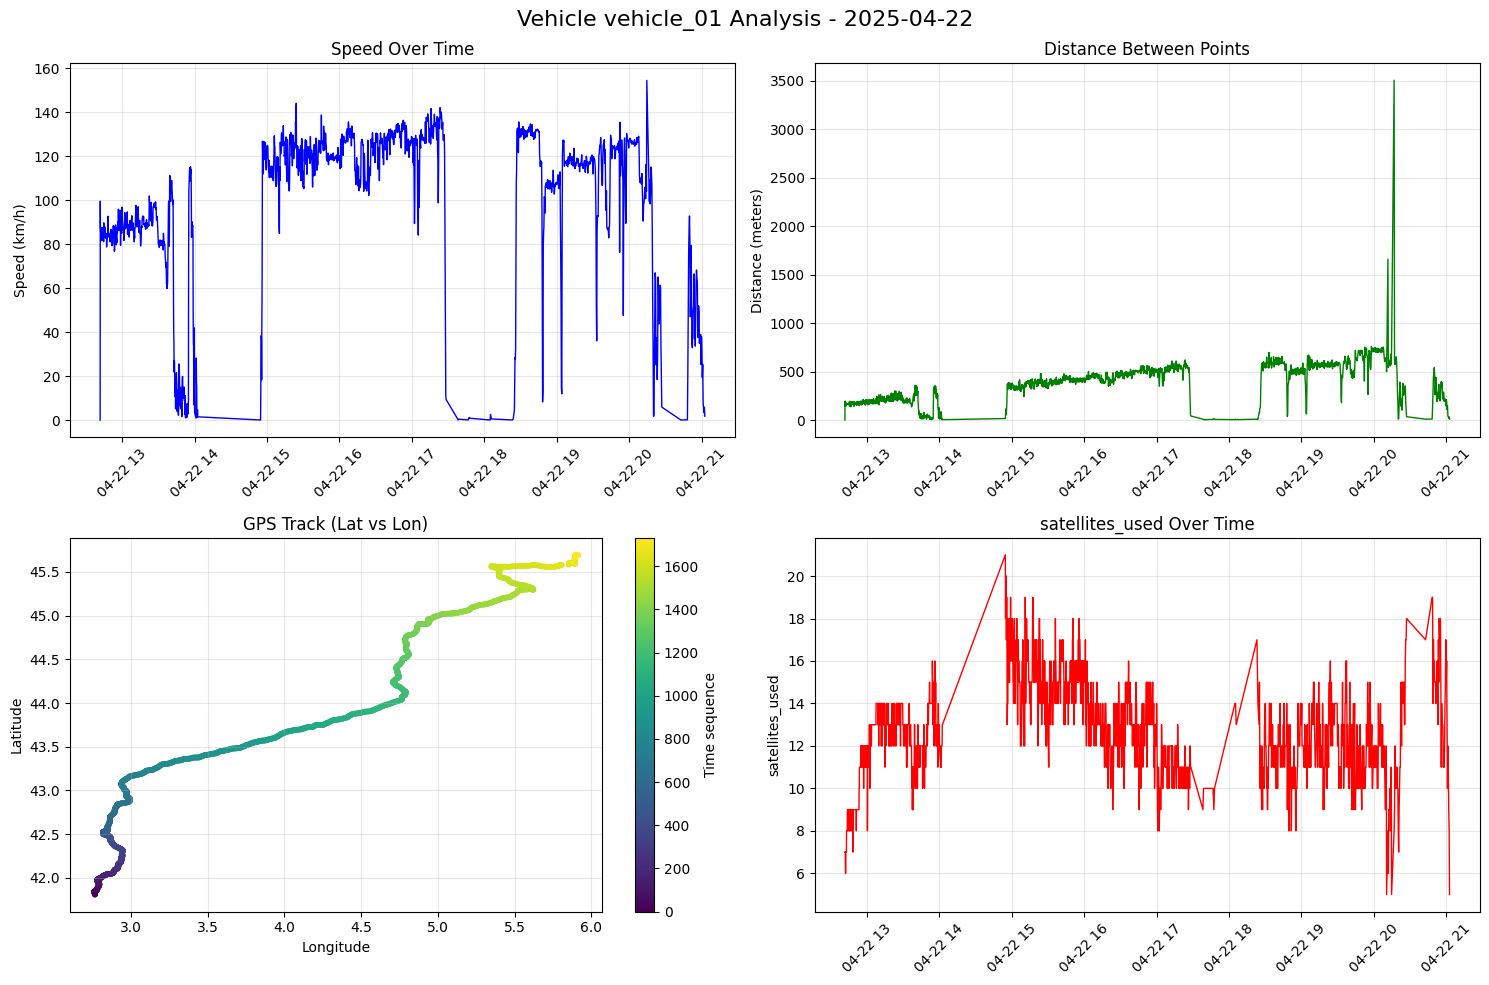


=== MOVEMENT ANALYSIS ===
Moving points: 1719 (99.2%)
Stopped points: 14 (0.8%)
Average speed while moving: 102.3 km/h
Maximum speed: 154.5 km/h


In [35]:
# Time series analysis and plots
if not df.empty and len(df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Vehicle {VEHICLE_ID} Analysis - {TARGET_DATE}', fontsize=16)
    
    # 1. Speed over time
    if 'speed_kmh' in df.columns:
        axes[0, 0].plot(df['datetime'], df['speed_kmh'], 'b-', linewidth=1)
        axes[0, 0].set_title('Speed Over Time')
        axes[0, 0].set_ylabel('Speed (km/h)')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Distance between consecutive points
    if 'distance_m' in df.columns:
        axes[0, 1].plot(df['datetime'], df['distance_m'], 'g-', linewidth=1)
        axes[0, 1].set_title('Distance Between Points')
        axes[0, 1].set_ylabel('Distance (meters)')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Latitude vs Longitude scatter
    scatter = axes[1, 0].scatter(df['lon'], df['lat'], c=range(len(df)), cmap='viridis', s=10)
    axes[1, 0].set_title('GPS Track (Lat vs Lon)')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 0], label='Time sequence')
    
    # 4. GPS quality metrics (if available)
    quality_cols = [col for col in df.columns if any(term in col.lower() for term in ['quality', 'satellites', 'accuracy'])]
    if quality_cols:
        col_to_plot = quality_cols[0]  # Plot the first quality metric found
        axes[1, 1].plot(df['datetime'], df[col_to_plot], 'r-', linewidth=1)
        axes[1, 1].set_title(f'{col_to_plot} Over Time')
        axes[1, 1].set_ylabel(col_to_plot)
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        # If no quality metrics, show hourly distribution
        df['hour'] = df['datetime'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        axes[1, 1].bar(hourly_counts.index, hourly_counts.values)
        axes[1, 1].set_title('Hourly Distribution of GPS Points')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Number of Points')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print("\n=== MOVEMENT ANALYSIS ===")
    if 'speed_kmh' in df.columns:
        moving_data = df[df['speed_kmh'] > 1]  # Points where vehicle is moving > 1 km/h
        stopped_data = df[df['speed_kmh'] <= 1]  # Points where vehicle is stopped
        
        print(f"Moving points: {len(moving_data)} ({len(moving_data)/len(df)*100:.1f}%)")
        print(f"Stopped points: {len(stopped_data)} ({len(stopped_data)/len(df)*100:.1f}%)")
        
        if len(moving_data) > 0:
            print(f"Average speed while moving: {moving_data['speed_kmh'].mean():.1f} km/h")
            print(f"Maximum speed: {df['speed_kmh'].max():.1f} km/h")
else:
    print("Insufficient data for time series analysis")

In [36]:
# Heat map of location density
if not df.empty and len(df) > 10:
    # Create heat map
    heat_map = folium.Map(
        location=[df['lat'].mean(), df['lon'].mean()],
        zoom_start=12
    )
    
    # Prepare heat data
    heat_data = [[row['lat'], row['lon']] for _, row in df.iterrows()]
    
    # Add heat map layer
    plugins.HeatMap(heat_data, radius=15).add_to(heat_map)
    
    # Add title
    title_html = f'<h3 align="center" style="font-size:16px"><b>Location Density Heat Map - Vehicle {VEHICLE_ID} - {TARGET_DATE}</b></h3>'
    heat_map.get_root().html.add_child(folium.Element(title_html))
    
    print("Location density heat map:")
    display(heat_map)
else:
    print("Insufficient data for heat map visualization")

Location density heat map:


In [37]:
# Data export options
if not df.empty:
    print("=== DATA EXPORT OPTIONS ===")
    
    # Save to CSV
    csv_filename = f'vehicle_{VEHICLE_ID}_{TARGET_DATE.replace("-", "_")}_gps_data.csv'
    df.to_csv(csv_filename, index=False)
    print(f"Data exported to CSV: {csv_filename}")
    
    # Save summary statistics
    summary_data = {
        'vehicle_id': VEHICLE_ID,
        'date': TARGET_DATE,
        'total_points': len(df),
        'start_time': df['datetime'].min().isoformat(),
        'end_time': df['datetime'].max().isoformat(),
        'duration_hours': (df['datetime'].max() - df['datetime'].min()).total_seconds() / 3600,
        'lat_min': float(df['lat'].min()),
        'lat_max': float(df['lat'].max()),
        'lon_min': float(df['lon'].min()),
        'lon_max': float(df['lon'].max())
    }
    
    if 'distance_m' in df.columns:
        summary_data['total_distance_km'] = float(df['distance_m'].sum() / 1000)
    
    if 'speed_kmh' in df.columns:
        summary_data['avg_speed_kmh'] = float(df[df['speed_kmh'] > 0]['speed_kmh'].mean())
        summary_data['max_speed_kmh'] = float(df['speed_kmh'].max())
    
    summary_filename = f'vehicle_{VEHICLE_ID}_{TARGET_DATE.replace("-", "_")}_summary.json'
    with open(summary_filename, 'w') as f:
        json.dump(summary_data, f, indent=2)
    print(f"Summary statistics exported to JSON: {summary_filename}")
    
    # Display final summary
    print("\n=== FINAL SUMMARY ===")
    for key, value in summary_data.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
else:
    print("No data available for export")

=== DATA EXPORT OPTIONS ===
Data exported to CSV: vehicle_vehicle_01_2025_04_22_gps_data.csv
Summary statistics exported to JSON: vehicle_vehicle_01_2025_04_22_summary.json

=== FINAL SUMMARY ===
vehicle_id: vehicle_01
date: 2025-04-22
total_points: 1733
start_time: 2025-04-22T12:41:46
end_time: 2025-04-22T21:02:42
duration_hours: 8.35
lat_min: 41.81
lat_max: 45.70
lon_min: 2.76
lon_max: 5.91
total_distance_km: 641.68
avg_speed_kmh: 101.53
max_speed_kmh: 154.47
